# Dependent multi-series forecasting (Multivariate forecasting)

In [univariate time series forecasting](https://joaquinamatrodrigo.github.io/skforecast/latest/quick-start/introduction-forecasting.html), a single time series is modeled as a linear or nonlinear combination of its lags, where past values of the series are used to forecast its future. In multi-series forecasting, two or more time series are modeled together using a single model.

In **dependent multi-series forecasting (multivariate time series)**, all series are modeled together in a single model, considering that each time series depends not only on its past values but also on the past values of the other series. The forecaster is expected not only to learn the information of each series separately but also to relate them. An example is the measurements made by all the sensors (flow, temperature, pressure...) installed on an industrial machine such as a compressor.

<p align="center"><img src="../img/forecaster_multivariate_train_matrix_diagram.png" style="width: 700px"></p>

<center><font size="2.5"> <i>Time series transformation to train a forecaster with multiple dependent time series.</i></font></center>

Since as many training matrices are created as there are series in the dataset, it must be decided on which level the forecasting will be performed. To predict the next *n* steps a model is trained for each step to be predicted, the selected level in the figure is `Series 1`. This strategy is of the type [direct multi-step forecasting](https://joaquinamatrodrigo.github.io/skforecast/latest/quick-start/introduction-forecasting.html#direct-multi-step-forecasting).

<p align="center"><img src="../img/forecaster_multivariate_prediction_diagram.png" style="width: 700px"></p>

<center><font size="2.5"> <i>Diagram of direct forecasting with multiple dependent time series.</i></font></center>


Using the `ForecasterAutoregMultiVariate` class, it is possible to easily build machine learning models for dependent multi-series forecasting.

<script src="https://kit.fontawesome.com/d20edc211b.js" crossorigin="anonymous"></script>

<div class="admonition note" name="html-admonition" style="background: rgba(0,184,212,.1); padding-top: 0px; padding-bottom: 6px; border-radius: 8px; border-left: 8px solid #00b8d4;">

<p class="title">
    <i class="fa-circle-exclamation fa" style="font-size: 18px; color:#00b8d4;"></i>
    <b> &nbsp Note</b>
</p>
    
See <a href="https://joaquinamatrodrigo.github.io/skforecast/latest/user_guides/multivariate-forecasting.html">ForecasterAutoregMultiSeries</a> for independent multi-series forecasting.

</div>

## Libraries

In [1]:
# Libraries
# ==============================================================================
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Ridge
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error

from skforecast.ForecasterAutoregMultiVariate import ForecasterAutoregMultiVariate
from skforecast.model_selection_multiseries import backtesting_forecaster_multiseries
from skforecast.model_selection_multiseries import grid_search_forecaster_multiseries
from skforecast.model_selection_multiseries import random_search_forecaster_multiseries

## Data

In [2]:
# Data download
# ==============================================================================
url = (
       'https://raw.githubusercontent.com/JoaquinAmatRodrigo/skforecast/master/'
       'data/guangyuan_air_pollution.csv'
)
data = pd.read_csv(url, sep=',')

# Data preparation
# ==============================================================================
data['date'] = pd.to_datetime(data['date'], format='%Y-%m-%d')
data = data.set_index('date')
data = data.asfreq('D')
data = data.sort_index()
data = data[['CO', 'SO2', 'PM2.5']]
data.head()

,CO,SO2,PM2.5
date,,,
2013-03-01,9600.0,204.0,181.0
2013-03-02,20198.0,674.0,633.0
2013-03-03,47195.0,1661.0,1956.0
2013-03-04,15000.0,485.0,438.0
2013-03-05,59594.0,2001.0,3388.0


In [3]:
# Split data into train-val-test
# ==============================================================================
end_train = '2016-05-31 23:59:00'
data_train = data.loc[:end_train, :].copy()
data_test  = data.loc[end_train:, :].copy()

print(
    f"Train dates : {data_train.index.min()} --- {data_train.index.max()}"
    f"(n={len(data_train)})"
)
print(
    f"Test dates  : {data_test.index.min()} --- {data_test.index.max()}"
    f"(n={len(data_test)})"
)

Train dates : 2013-03-01 00:00:00 --- 2016-05-31 00:00:00(n=1188)
Test dates  : 2016-06-01 00:00:00 --- 2017-02-28 00:00:00(n=273)


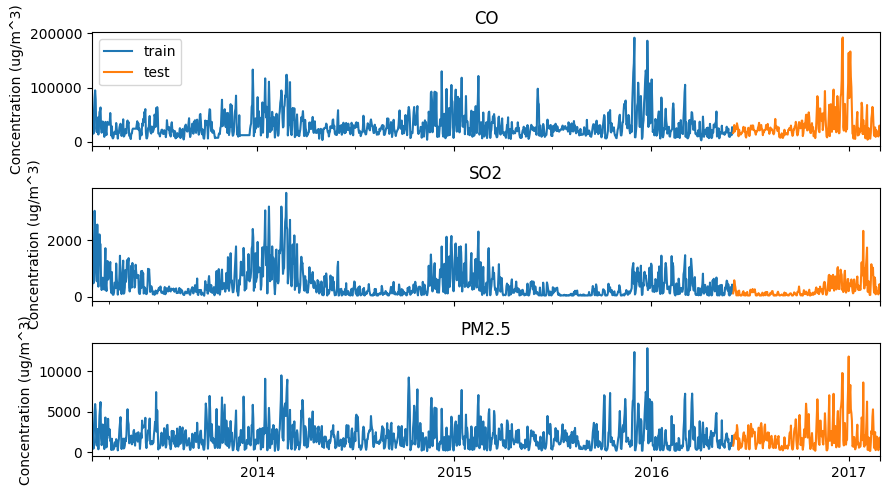

In [4]:
# Plot time series
# ==============================================================================
fig, axes = plt.subplots(nrows=3, ncols=1, figsize=(9, 5), sharex=True)

data_train['CO'].plot(label='train', ax=axes[0])
data_test['CO'].plot(label='test', ax=axes[0])
axes[0].set_xlabel('')
axes[0].set_ylabel('Concentration (ug/m^3)')
axes[0].set_title('CO')
axes[0].legend()

data_train['SO2'].plot(label='train', ax=axes[1])
data_test['SO2'].plot(label='test', ax=axes[1])
axes[1].set_xlabel('')
axes[1].set_ylabel('Concentration (ug/m^3)')
axes[1].set_title('SO2')

data_train['PM2.5'].plot(label='train', ax=axes[2])
data_test['PM2.5'].plot(label='test', ax=axes[2])
axes[2].set_xlabel('')
axes[2].set_ylabel('Concentration (ug/m^3)')
axes[2].set_title('PM2.5')

fig.tight_layout()
plt.show();

## Train and predict ForecasterAutoregMultiVariate

When initializing the forecaster, the `level` to be predicted and the maximum number of `steps` must be indicated since a different model will be created for each step.

In [5]:
# Create and fit forecaster MultiVariate
# ==============================================================================
forecaster = ForecasterAutoregMultiVariate(
                 regressor          = Ridge(random_state=123),
                 level              = 'CO',
                 lags               = 7,
                 steps              = 7,
                 transformer_series = None,
                 transformer_exog   = None,
                 weight_func        = None
             )

forecaster.fit(series=data_train)
forecaster

ForecasterAutoregMultiVariate 
Regressor: Ridge(random_state=123) 
Lags: [1 2 3 4 5 6 7] 
Transformer for series: None 
Transformer for exog: None 
Weight function included: False 
Window size: 7 
Target series, level: CO 
Multivariate series (names): ['CO', 'SO2', 'PM2.5'] 
Maximum steps predicted: 7 
Exogenous included: False 
Type of exogenous variable: None 
Exogenous variables names: None 
Training range: [Timestamp('2013-03-01 00:00:00'), Timestamp('2016-05-31 00:00:00')] 
Training index type: DatetimeIndex 
Training index frequency: D 
Regressor parameters: {'alpha': 1.0, 'copy_X': True, 'fit_intercept': True, 'max_iter': None, 'positive': False, 'random_state': 123, 'solver': 'auto', 'tol': 0.0001} 
fit_kwargs: {} 
Creation date: 2023-05-16 07:57:10 
Last fit date: 2023-05-16 07:57:10 
Skforecast version: 0.8.0 
Python version: 3.10.9 
Forecaster id: None 

When predicting, the value of `steps` must be less than or equal to the value of steps defined when initializing the forecaster. Starts at 1.

+ If `int` only steps within the range of 1 to int are predicted.

+ If `list` of `int`. Only the steps contained in the list are predicted.

+ If `None` as many steps are predicted as were defined at initialization.

In [6]:
# Predict with forecaster MultiVariate
# ==============================================================================
# Predict as many steps as defined in the forecaster initialization
predictions = forecaster.predict()
display(predictions)

,CO
2016-06-01,20244.442039
2016-06-02,23307.697174
2016-06-03,22487.345075
2016-06-04,23111.643246
2016-06-05,24686.327128
2016-06-06,24023.210710
2016-06-07,24015.607873


In [7]:
# Predict only a subset of steps
predictions = forecaster.predict(steps=[1, 5])
display(predictions)

,CO
2016-06-01,20244.442039
2016-06-05,24686.327128


In [8]:
# Predict with prediction intervals
predictions = forecaster.predict_interval()
display(predictions)

,CO,lower_bound,upper_bound
2016-06-01,20244.442039,-80.146735,47276.760018
2016-06-02,23307.697174,-2170.152743,63078.155420
2016-06-03,22487.345075,-4504.802798,64369.052985
2016-06-04,23111.643246,-1760.325312,58465.948430
2016-06-05,24686.327128,981.755673,55560.773066
2016-06-06,24023.210710,-327.970078,60295.211096
2016-06-07,24015.607873,-1438.003274,64567.853999


## Backtesting MultiVariate

See the [backtesting user guide](https://joaquinamatrodrigo.github.io/skforecast/latest/user_guides/backtesting.html) to learn more about backtesting.

In [9]:
# Backtesting MultiVariate
# ==============================================================================
metrics_levels, backtest_predictions = backtesting_forecaster_multiseries(
                                           forecaster         = forecaster,
                                           series             = data,
                                           steps              = 7,
                                           metric             = 'mean_absolute_error',
                                           initial_train_size = len(data_train),
                                           refit              = False,
                                           fixed_train_size   = False,
                                           verbose            = False
                                       )

print("Backtest metrics")
display(metrics_levels)
print("")
print("Backtest predictions")
backtest_predictions.head(4)

  0%|          | 0/39 [00:00<?, ?it/s]

Backtest metrics


,levels,mean_absolute_error
0,CO,14931.121425



Backtest predictions


,CO
2016-06-01,20244.442039
2016-06-02,23307.697174
2016-06-03,22487.345075
2016-06-04,23111.643246


## Hyperparameter tuning and lags selection MultiVariate

Functions `grid_search_forecaster_multiseries` and `random_search_forecaster_multiseries` in the module `model_selection_multiseries` allow for lag and hyperparameter optimization. The optimization is performed in the same way as in the other forecasters, [see the user guide here](https://joaquinamatrodrigo.github.io/skforecast/latest/user_guides/hyperparameter-tuning-and-lags-selection.html).

The following example shows how to use `random_search_forecaster_multiseries` to find the best lags and model hyperparameters for all time series:

In [10]:
# Create and forecaster MultiVariate
# ==============================================================================
forecaster = ForecasterAutoregMultiVariate(
                 regressor          = RandomForestRegressor(random_state=123),
                 level              = 'CO',
                 lags               = 7,
                 steps              = 7,
                 transformer_series = None,
                 transformer_exog   = None,
                 weight_func        = None
             )

In [11]:
# Random search MultiVariate
# ==============================================================================
lags_grid = [7, 14]
param_distributions = {
    'n_estimators': np.arange(start=10, stop=20, step=1, dtype=int),
    'max_depth': np.arange(start=3, stop=6, step=1, dtype=int)
}

results = random_search_forecaster_multiseries(
              forecaster          = forecaster,
              series              = data,
              exog                = None,
              lags_grid           = lags_grid,
              param_distributions = param_distributions,
              steps               = 7,
              metric              = 'mean_absolute_error',
              initial_train_size  = len(data_train),
              refit               = False,
              fixed_train_size    = False,
              n_iter              = 5,
              return_best         = False,
              verbose             = False
          )

results

10 models compared for 1 level(s). Number of iterations: 10.


lags grid:   0%|          | 0/2 [00:00<?, ?it/s]

params grid:   0%|          | 0/5 [00:00<?, ?it/s]

params grid:   0%|          | 0/5 [00:00<?, ?it/s]

,levels,lags,params,mean_absolute_error,n_estimators,max_depth
7,[CO],"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14]","{'n_estimators': 15, 'max_depth': 3}",15991.360494,15,3
5,[CO],"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14]","{'n_estimators': 17, 'max_depth': 3}",16001.390244,17,3
9,[CO],"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14]","{'n_estimators': 18, 'max_depth': 3}",16058.419766,18,3
8,[CO],"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14]","{'n_estimators': 16, 'max_depth': 5}",16160.441414,16,5
6,[CO],"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14]","{'n_estimators': 19, 'max_depth': 5}",16192.047506,19,5
3,[CO],"[1, 2, 3, 4, 5, 6, 7]","{'n_estimators': 16, 'max_depth': 5}",16195.444749,16,5
4,[CO],"[1, 2, 3, 4, 5, 6, 7]","{'n_estimators': 18, 'max_depth': 3}",16203.381611,18,3
1,[CO],"[1, 2, 3, 4, 5, 6, 7]","{'n_estimators': 19, 'max_depth': 5}",16269.039511,19,5
0,[CO],"[1, 2, 3, 4, 5, 6, 7]","{'n_estimators': 17, 'max_depth': 3}",16303.094588,17,3
2,[CO],"[1, 2, 3, 4, 5, 6, 7]","{'n_estimators': 15, 'max_depth': 3}",16354.631284,15,3


## Different lags for each time series

If a `dict` is passed to the `lags` argument, it allows setting different lags for each of the series. 

In [12]:
# Create and fit forecaster MultiVariate Custom lags
# ==============================================================================
forecaster = ForecasterAutoregMultiVariate(
                 regressor          = Ridge(random_state=123),
                 level              = 'CO',
                 lags               = {'CO': 7, 'SO2': [1, 7], 'PM2.5': 2},
                 steps              = 7,
                 transformer_series = None,
                 transformer_exog   = None,
                 weight_func        = None
             )

forecaster.fit(series=data_train)

# Predict
# ==============================================================================
predictions = forecaster.predict(steps=7)
display(predictions)

,CO
2016-06-01,19421.982426
2016-06-02,21856.950600
2016-06-03,21910.011418
2016-06-04,23197.353798
2016-06-05,23294.891733
2016-06-06,22478.158677
2016-06-07,23393.641623


It is possible to use the `create_train_X_y` method to generate the matrices that the forecaster is using to train the model. This approach enables gaining insight into the specific lags that have been created.

In [13]:
# Extract training matrix
# ==============================================================================
X, y = forecaster.create_train_X_y(series=data_train)

# X and y to train model for step 1
X_1, y_1 = forecaster.filter_train_X_y_for_step(
               step    = 1,
               X_train = X,
               y_train = y,
           )

X_1.head(4)

,CO_lag_1,CO_lag_2,CO_lag_3,CO_lag_4,CO_lag_5,CO_lag_6,CO_lag_7,SO2_lag_1,SO2_lag_7,PM2.5_lag_1,PM2.5_lag_2
date,,,,,,,,,,,
2013-03-14,94792.0,81291.0,59594.0,15000.0,47195.0,20198.0,9600.0,2369.0000,204.0,5952.0,4934.0
2013-03-15,78194.0,94792.0,81291.0,59594.0,15000.0,47195.0,20198.0,1535.5424,674.0,5039.0,5952.0
2013-03-16,24596.0,78194.0,94792.0,81291.0,59594.0,15000.0,47195.0,881.0000,1661.0,1242.0,5039.0
2013-03-17,17600.0,24596.0,78194.0,94792.0,81291.0,59594.0,15000.0,553.0000,485.0,818.0,1242.0


## Weights in MultiVariate

The weights are used to control the influence that each observation has on the training of the model.

Learn more about [weighted time series forecasting](https://joaquinamatrodrigo.github.io/skforecast/latest/user_guides/weighted-time-series-forecasting.html) with skforecast.

In [14]:
# Weights in MultiVariate
# ==============================================================================
def custom_weights(index):
    """
    Return 0 if index is between '2013-01-01' and '2013-01-31', 1 otherwise.
    """
    weights = np.where(
                  (index >= '2013-01-01') & (index <= '2013-01-31'),
                   0,
                   1
              )
    
    return weights

forecaster = ForecasterAutoregMultiVariate(
                 regressor          = Ridge(random_state=123),
                 level              = 'CO',
                 lags               = 7,
                 steps              = 7,
                 transformer_series = None,
                 transformer_exog   = None,
                 weight_func        = custom_weights
             )

forecaster.fit(series=data_train)
forecaster.predict(steps=7).head(3)

,CO
2016-06-01,20244.442039
2016-06-02,23307.697174
2016-06-03,22487.345075


<script src="https://kit.fontawesome.com/d20edc211b.js" crossorigin="anonymous"></script>

<div class="admonition warning" name="html-admonition" style="background: rgba(255,145,0,.1); padding-top: 0px; padding-bottom: 6px; border-radius: 8px; border-left: 8px solid #ff9100;">

<p class="title">
    <i class="fa-triangle-exclamation fa" style="font-size: 18px; color:#ff9100;"></i>
    <b> &nbsp Warning</b>
</p>

The <code>weight_func</code> argument will be ignored if the regressor does not accept <code>sample_weight</code> in its <code>fit</code> method.

</div>

The source code of the `weight_func` added to the forecaster is stored in the argument `source_code_weight_func`.

In [15]:
print(forecaster.source_code_weight_func)

def custom_weights(index):
    """
    Return 0 if index is between '2013-01-01' and '2013-01-31', 1 otherwise.
    """
    weights = np.where(
                  (index >= '2013-01-01') & (index <= '2013-01-31'),
                   0,
                   1
              )
    
    return weights



## Scikit-learn transformers in MultiVariate

Learn more about [using scikit-learn transformers](https://joaquinamatrodrigo.github.io/skforecast/latest/user_guides/sklearn-transformers-and-pipeline.html) with skforecast.

+  If `transformer_series` is a `transformer` the same transformation will be applied to all series. 
+  If `transformer_series` is a `dict` a different transformation can be set for each series. Series not present in the dict will not have any transformation applied to them.

In [16]:
forecaster = ForecasterAutoregMultiVariate(
                 regressor          = Ridge(random_state=123),
                 level              = 'CO',
                 lags               = 7,
                 steps              = 7,
                 transformer_series = {'CO': StandardScaler(), 'SO2': StandardScaler()},
                 transformer_exog   = None,
                 weight_func        = None,
             )

forecaster.fit(series=data_train)
forecaster

/home/ubuntu/anaconda3/envs/skforecast_py10/lib/python3.10/site-packages/skforecast/ForecasterAutoregMultiVariate/ForecasterAutoregMultiVariate.py:506: IgnoredArgumentWarning: {'PM2.5'} not present in `transformer_series`. No transformation is applied to these series. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=LongTrainingWarning)
  warnings.warn(


ForecasterAutoregMultiVariate 
Regressor: Ridge(random_state=123) 
Lags: [1 2 3 4 5 6 7] 
Transformer for series: {'CO': StandardScaler(), 'SO2': StandardScaler()} 
Transformer for exog: None 
Weight function included: False 
Window size: 7 
Target series, level: CO 
Multivariate series (names): ['CO', 'SO2', 'PM2.5'] 
Maximum steps predicted: 7 
Exogenous included: False 
Type of exogenous variable: None 
Exogenous variables names: None 
Training range: [Timestamp('2013-03-01 00:00:00'), Timestamp('2016-05-31 00:00:00')] 
Training index type: DatetimeIndex 
Training index frequency: D 
Regressor parameters: {'alpha': 1.0, 'copy_X': True, 'fit_intercept': True, 'max_iter': None, 'positive': False, 'random_state': 123, 'solver': 'auto', 'tol': 0.0001} 
fit_kwargs: {} 
Creation date: 2023-05-16 07:57:36 
Last fit date: 2023-05-16 07:57:36 
Skforecast version: 0.8.0 
Python version: 3.10.9 
Forecaster id: None 

## Compare multiple metrics

All three functions (`backtesting_forecaster_multiseries`, `grid_search_forecaster_multiseries`, and `random_search_forecaster_multiseries`) allow the calculation of multiple metrics for each forecaster configuration if a list is provided. This list may include custom metrics and the best model selection is done based on the first metric of the list.

In [17]:
# Grid search MultiVariate with multiple metrics
# ==============================================================================
forecaster = ForecasterAutoregMultiVariate(
                 regressor          = Ridge(random_state=123),
                 level              = 'CO',
                 lags               = 7,
                 steps              = 7
             )    

def custom_metric(y_true, y_pred):
    """
    Calculate the mean absolute error using only the predicted values of the last
    3 months of the year.
    """
    mask = y_true.index.month.isin([10, 11, 12])
    metric = mean_absolute_error(y_true[mask], y_pred[mask])
    
    return metric

lags_grid = [7, 14]
param_grid = {'alpha': [0.01, 0.1, 1]}

results = grid_search_forecaster_multiseries(
              forecaster          = forecaster,
              series              = data,
              exog                = None,
              steps               = 7,
              metric              = [mean_absolute_error, custom_metric, 'mean_squared_error'],
              lags_grid           = lags_grid,
              param_grid          = param_grid,
              initial_train_size  = len(data_train),
              refit               = False,
              fixed_train_size    = False,
              return_best         = True,
              verbose             = False
          )

results

6 models compared for 1 level(s). Number of iterations: 6.


lags grid:   0%|          | 0/2 [00:00<?, ?it/s]

params grid:   0%|          | 0/3 [00:00<?, ?it/s]

params grid:   0%|          | 0/3 [00:00<?, ?it/s]

`Forecaster` refitted using the best-found lags and parameters, and the whole data set: 
  Lags: [1 2 3 4 5 6 7]
  Parameters: {'alpha': 1}
  Backtesting metric: 14931.121425356869
  Levels: ['CO']



,levels,lags,params,mean_absolute_error,custom_metric,mean_squared_error,alpha
2,[CO],"[1, 2, 3, 4, 5, 6, 7]",{'alpha': 1},14931.121425,21210.876663,5.519094e+08,1.00
1,[CO],"[1, 2, 3, 4, 5, 6, 7]",{'alpha': 0.1},14931.121426,21210.876659,5.519094e+08,0.10
0,[CO],"[1, 2, 3, 4, 5, 6, 7]",{'alpha': 0.01},14931.121426,21210.876659,5.519094e+08,0.01
5,[CO],"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14]",{'alpha': 1},15019.782237,20996.998181,5.649121e+08,1.00
4,[CO],"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14]",{'alpha': 0.1},15019.782238,20996.998178,5.649121e+08,0.10
3,[CO],"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14]",{'alpha': 0.01},15019.782238,20996.998178,5.649121e+08,0.01


## Feature importances

Since `ForecasterAutoregMultiVariate` fits one model per step, it is necessary to specify from which model retrieves its feature importances.

In [18]:
forecaster.get_feature_importances(step=1)

,feature,importance
0,CO_lag_1,0.655461
1,CO_lag_2,-0.072108
2,CO_lag_3,0.097851
3,CO_lag_4,0.055877
4,CO_lag_5,0.067536
5,CO_lag_6,-0.122215
6,CO_lag_7,0.115945
7,SO2_lag_1,5.336658
8,SO2_lag_2,-1.074241
9,SO2_lag_3,-3.647177


## Extract training matrix

Two steps are needed. One to create the whole training matrix and a second one to subset the data needed for each model (step).

In [19]:
# Extract training matrix
# ==============================================================================
X, y = forecaster.create_train_X_y(series=data_train)

# X and y to train model for step 1
X_1, y_1 = forecaster.filter_train_X_y_for_step(
               step    = 1,
               X_train = X,
               y_train = y,
           )

X_1.head(4)

,CO_lag_1,CO_lag_2,CO_lag_3,CO_lag_4,CO_lag_5,CO_lag_6,CO_lag_7,SO2_lag_1,SO2_lag_2,SO2_lag_3,...,SO2_lag_5,SO2_lag_6,SO2_lag_7,PM2.5_lag_1,PM2.5_lag_2,PM2.5_lag_3,PM2.5_lag_4,PM2.5_lag_5,PM2.5_lag_6,PM2.5_lag_7
date,,,,,,,,,,,,,,,,,,,,,
2013-03-14,94792.0,81291.0,59594.0,15000.0,47195.0,20198.0,9600.0,2369.0000,3052.0000,2001.0000,...,1661.0,674.0,204.0,5952.0,4934.0,3388.0,438.0,1956.0,633.0,181.0
2013-03-15,78194.0,94792.0,81291.0,59594.0,15000.0,47195.0,20198.0,1535.5424,2369.0000,3052.0000,...,485.0,1661.0,674.0,5039.0,5952.0,4934.0,3388.0,438.0,1956.0,633.0
2013-03-16,24596.0,78194.0,94792.0,81291.0,59594.0,15000.0,47195.0,881.0000,1535.5424,2369.0000,...,2001.0,485.0,1661.0,1242.0,5039.0,5952.0,4934.0,3388.0,438.0,1956.0
2013-03-17,17600.0,24596.0,78194.0,94792.0,81291.0,59594.0,15000.0,553.0000,881.0000,1535.5424,...,3052.0,2001.0,485.0,818.0,1242.0,5039.0,5952.0,4934.0,3388.0,438.0


In [20]:
y_1.head(4)

date
2013-03-14    78194.0
2013-03-15    24596.0
2013-03-16    17600.0
2013-03-17    40794.0
Freq: D, Name: CO_step_1, dtype: float64

<script src="https://kit.fontawesome.com/d20edc211b.js" crossorigin="anonymous"></script>

<div class="admonition note" name="html-admonition" style="background: rgba(255,145,0,.1); padding-top: 0px; padding-bottom: 6px; border-radius: 8px; border-left: 8px solid #ff9100;">

<p class="title">
    <i class="fa-triangle-exclamation fa" style="font-size: 18px; color:#ff9100;"></i>
    <b> &nbsp Warning</b>
</p>

<code>bayesian_search_forecaster_multiseries</code> will be released in a future version of <b>Skforecast</b>
<br>
Stay tuned!

</div>

In [21]:
%%html
<style>
.jupyter-wrapper .jp-CodeCell .jp-Cell-inputWrapper .jp-InputPrompt {display: none;}
</style>